# TP3 PART 2 INF372 : APPRENTISSAGE SUPERVISE ET NON SUPERVISE

## Membre du groupe :
- FOSSI TALLA JORDANE (20U2878)
- MAKOU FOKOUA PATRICIA (21T2446)
- MEKA MOISE CHRISTIAN JUNIOR (21T2561)
- RUDY TCHAMBA TCHAPTCHE ITIEL (21T2981)

## Objectif du TP

Il s'agit d'implémenter un MLP (MultiLayer Perceptron) sur l’ensemble de données CIFAR10 constitué d'images d'objets. L'idée étant à partir d'image, de prédire l'objet se trouvant sur l'image celà en utilisant le MLP. \
Pour se faire, nous allons procéder en plusieurs étapes :
1. Importation des données
2. Définition le modèle
3. Définition la fonction de perte et les optimiseurs
4. Entraînement du modèle
5. Évaluer le modèle

Dans le cadre de cet exercice, nous utiliseron le package *PyToch*

In [1]:
#Chargement des packages necessaires
import random
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as datasets

## Importation des données

In [2]:
#Chargement des données
SEED_VALUE = 42
def seed_random():

    # Fix seed to make training deterministic.
    random.seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)

In [3]:
train_all=datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
test=datasets.CIFAR10(root='./data', train=False, download=True, transform=None)

100%|██████████| 170498071/170498071 [00:12<00:00, 13388494.25it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Après avoir importé les données nous les diviserons en données d'entrainement et données de test car à la fin de notre process nous évaluer le modèle et faire des prévisions

In [4]:
X_train_all=[]
y_train_all=[]
for i in range(len(train_all)) :
    X_train_all.append(train_all[i][0])
    y_train_all.append(train_all[i][1])

X_test=[]
y_test=[]
for i in range(len(test)):
    X_test.append(test[i][0])
    y_test.append(test[i][1])

X_train_all=np.array(X_train_all)
y_train_all=np.array(y_train_all)
y_test=np.array(y_test)
X_test=np.array(X_test)

In [5]:
#On défini un état aléatoire
seed_random()

#On sélectionne les 10000 observations pour le validset
id_valid=random.sample(range(X_train_all.shape[0]), 10000)
X_valid = X_train_all[id_valid]
y_valid = y_train_all[id_valid]

#On sélectionne le reste pour le Trainset
id_train=np.setdiff1d(np.arange(0, X_train_all.shape[0]), id_valid)
X_train = X_train_all[id_train]
y_train = y_train_all[id_train]

#On affiche les dimmensions de nos ensembles de données Train-Valid-Test
print("Train : ",X_train.shape)
print("Valid : ",X_valid.shape)
print("Test : ",X_test.shape)

Train :  (40000, 32, 32, 3)
Valid :  (10000, 32, 32, 3)
Test :  (10000, 32, 32, 3)


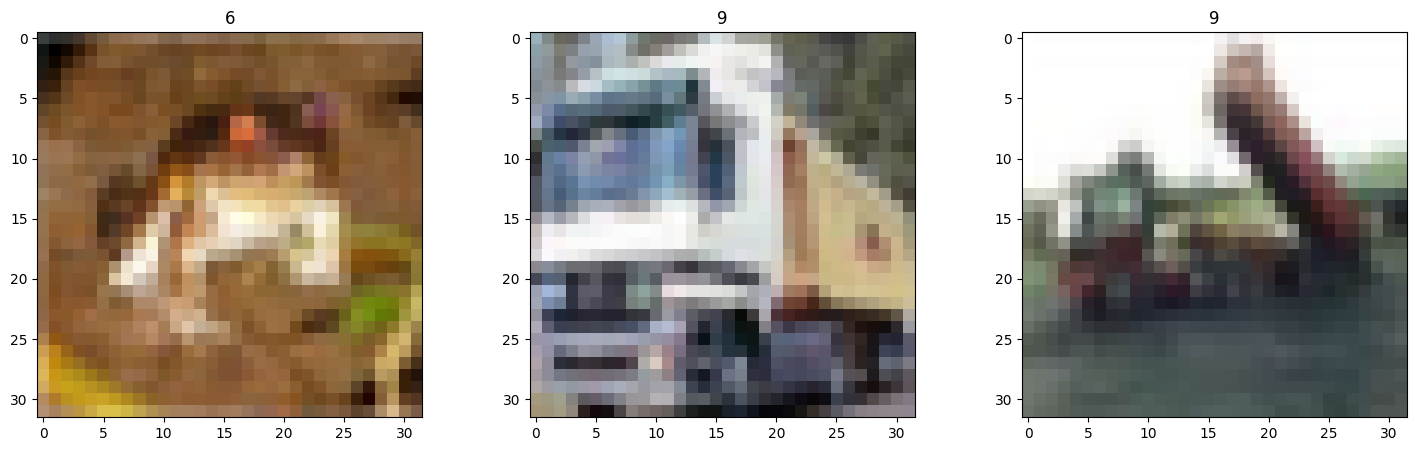

In [6]:
#On affiche en suite quelques images du trainset
plt.figure(figsize=(18, 5))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.axis(True)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(y_train[i])
    plt.subplots_adjust(wspace=0.2, hspace=0.2)

## Transformation des données

In [7]:
#Normalisation des images
X_train = X_train.reshape((X_train.shape[0], -1))
X_train = X_train.astype("float32") / 255

X_valid = X_valid.reshape((X_valid.shape[0], -1))
X_valid = X_valid.astype("float32") / 255

X_test = X_test.reshape((X_test.shape[0], -1))
X_test = X_test.astype("float32") / 255

In [8]:
def to_categorical(y):
    n_cls=max(y)+1
    res = np.zeros((y.size, n_cls), dtype=float)
    res[np.arange(y.size), y] = 1.0
    return res

In [9]:
y_train = to_categorical(y_train)
y_test  = to_categorical(y_test)
y_valid  = to_categorical(y_valid)
for i in range(3):
    print(y_train[i])

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [10]:
X_train=torch.tensor(X_train)
X_test=torch.tensor(X_test)
y_train=torch.tensor(y_train)
y_test=torch.tensor(y_test)
X_valid=torch.tensor(X_valid)
y_valid=torch.tensor(y_valid)

## Définition du modèle

Le MLP que nous allons construire dans le cadre de ce TP sera constitué d'une séquence de couches définies comme suit :
- Couche d'entrée à 8 neurones car nos observation comportes 8 attributs
- Deux couches cachées avec 12 neurones pour la première et 8 pour la seconde. l'activation utilisée sera ReLU
- Une couche de sortie à un seul neurone. Vu que nous sommes en classification binaire, l'activation ici sera Sigmoid

Du point de vu de PyTorch, il existe deux façon de définir un tel modèle séquentiel (Soit en instanciant un modèle séquentiel et en lui ajoutant les différentes couches, soit en créant une classe qui héritera de *nn.Model*). Mais dans le cadre de ce TP nous opterons pour la première méthode.

In [11]:
model = nn.Sequential()
model.add_module("dense1", nn.Linear(X_train.shape[1], 128))
model.add_module("act1", nn.ReLU())
model.add_module("dense2", nn.Linear(128, 10))
model.add_module("act2", nn.ReLU())
model.add_module("output", nn.Linear(10, 10))
model.add_module("outact", nn.Sigmoid())

In [12]:
#Resumé du modèle défini
print(model)

Sequential(
  (dense1): Linear(in_features=3072, out_features=128, bias=True)
  (act1): ReLU()
  (dense2): Linear(in_features=128, out_features=10, bias=True)
  (act2): ReLU()
  (output): Linear(in_features=10, out_features=10, bias=True)
  (outact): Sigmoid()
)


## Définition la fonction de perte et les optimiseurs

Après avoir défini le défini le modèle, nous poursuivons dans notre process avec la définition de la fonction de perte et de l'optimiseur. En effet, ce sont ces deux éléments qui permettront à notre modèle d'apprendre des données qui lui sont fornis celà en mettant à jour les poids du modèle et en minimisant les erreurs à la préduction (Ecart entre valeur prédite et valeur réel).\
Dans le cadre de ce TP nous utiliserons :
- La fontion de perte Cross Entropy : Qui est la fonction loss utilisé lors des classifications multiclasse,
- Optimiseur Adam.

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001) #lr ici est le taux d'apprentissage

## Entraînement du modèle

Dans le cadre de l'entrainement de notre modèle, nous allons faire un Mini BGD (Batch Gradient Descent) pour y faire passer nos données par lot dans le modèle et mettre à jour les poids à chaque itération.

In [14]:
from tqdm import tqdm
def training_model(n_epochs, batch_size, X_train, y_train, model, optimizer, loss_fn):
    loss_train=list()
    accuracy=list()
    for epoch in range(n_epochs):
        for  batch in range(0, len(X_train), batch_size):

          # Get the batch data
          Xbatch = X_train[batch * batch_size:(batch + 1) * batch_size]
          ybatch = y_train[batch * batch_size:(batch + 1) * batch_size]

          # Forward pass
          y_pred = model(Xbatch)

          # Calculate the loss
          loss = loss_fn(y_pred, ybatch)

          # Backward pass
          optimizer.zero_grad()
          loss.backward()

          # Update the model parameters
          optimizer.step()

          loss_train.append(loss.detach().numpy())
          accuracy.append((y_pred.round() == ybatch).float().mean())
        print(f'Finished epoch {epoch}, latest loss {loss_train[epoch]}')
    return (loss_train, accuracy)

In [15]:
n_epochs = 10
batch_size = 41

loss_train, accuracy = training_model(n_epochs, batch_size, X_train, y_train, model, optimizer, loss_fn)

Finished epoch 0, latest loss 2.3109932643611257
Finished epoch 1, latest loss 2.3444927203945998
Finished epoch 2, latest loss 2.341746350614036
Finished epoch 3, latest loss 2.3550524391779084
Finished epoch 4, latest loss 2.3307245155660117
Finished epoch 5, latest loss 2.420097877339619
Finished epoch 6, latest loss 2.33176872788406
Finished epoch 7, latest loss 2.3260006352168756
Finished epoch 8, latest loss 2.310138562830483
Finished epoch 9, latest loss 2.299115849704277


In [16]:
import matplotlib.pyplot as plt
import matplotlib

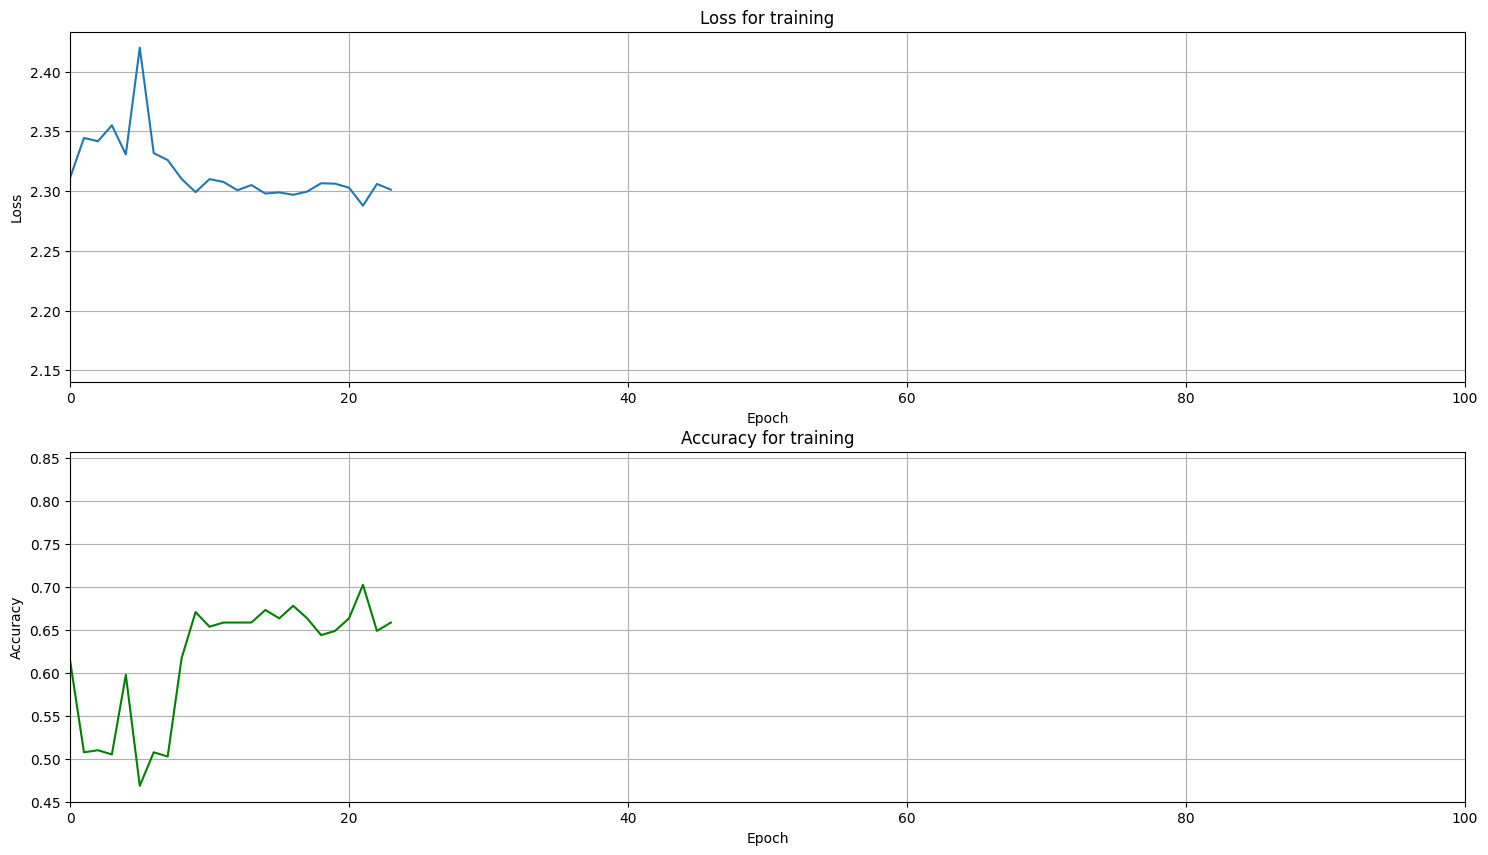

In [17]:
plt.figure(figsize=(18, 10))
plt.subplot(2, 1, 1)
plt.plot(loss_train)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xlim([0,100])
plt.title('Loss for training')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(accuracy, c='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xlim([0,100])
plt.title('Accuracy for training')
plt.grid(True)
plt.show()
plt.close()

## Evaluation du modèle

Le modèle entrainé doit être évalué. Dans un premier temps nous utiliserons l'accuracy et dans un second temps nous allons contruire une matrice de confusion.

In [18]:
with torch.no_grad():
    predictions = (model(X_test) > 0.5).int()

accuracy = (predictions.round() == y_test).float().mean()
print(f"Accuracy {accuracy}")

Accuracy 0.6593300104141235


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer

# Ces transformations sont effectuées car confusion_matrix de sklearn n'est valide que pour les classifications binaires
mlb = MultiLabelBinarizer()
y_test = mlb.fit_transform(y_test)
predictions = mlb.transform(predictions)

cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=[15, 8])
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d', annot_kws={"size": 14})
plt.xlabel('Prediction')
plt.ylabel('Reel')
plt.show()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
torch.save(model, "my_model.pickle")